# Monitors

@[Chaoming Wang](https://github.com/chaoming0625)
@[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn)

BrainPy has a [systematic naming system](../tutorial_math/base.ipynb). Any model in BrainPy have a unique name. Thus, nodes, integrators, and variables can be easily accessed in a huge network. Based on this naming system, BrainPy provides a set of convenient monitoring supports. In this section, we are going to talk about this. 

In [1]:
import brainpy as bp
import brainpy.math as bm

bp.math.set_platform('cpu')
bp.math.set_dt(0.02)

## Initializing Monitors in a Runner

In BrainPy, any instance of ``brainpy.Runner`` has a built-in monitor. Users can set up a monitor when initializing a runner. 

For example, if we want to simulate a Hodgkin-Hoxley (HH) model and monitor its membrane potential $V$ and the spikes it generates:

In [2]:
HH = bp.dyn.HH
model  = HH(1)

After defining a HH neuron, we can add monitors while setting up the runner. When specifying the `monitors` parameter, a monitor, which is an instance of ``brainpy.Monitor``, will be initialized. The first method to initialize a monitor is through a list/tuple of strings:

In [3]:
# set up a monitor using a list of str
runner1 = bp.dyn.DSRunner(model,
                          monitors=['V', 'spike'], 
                          inputs=('input', 10))

type(runner1.mon)

brainpy.running.monitor.Monitor

where the string `'V'` and `'spike'` corresponds to the name of the variables in the HH model:

In [4]:
model.V, model.spike

(Variable([-68.89985], dtype=float32), Variable([False], dtype=bool))

Besides using a list/tuple of strings, users can also directly use the ``Monitor`` class to initialize a monitor:

In [5]:
# set up a monitor using brainpy.Monitor
runner2 = bp.StructRunner(model, monitors=bp.Monitor(variables=['V', 'spike']))

Once we call the runner with a given time duration, the monitor will automatically record the variable evolutions in the corresponding models. Afterwards, users can access these variable trajectories by using ``.mon.[variable_name]``. The default history times ``.mon.ts`` will also be generated after the model finishes its running. Let's see an example. 

  0%|          | 0/5000 [00:00<?, ?it/s]

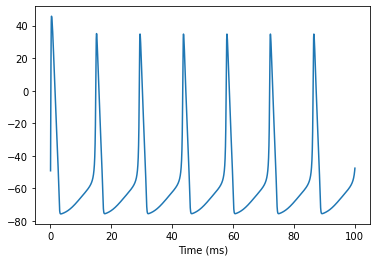

In [6]:
runner1(100.)

bp.visualize.line_plot(runner1.mon.ts, runner1.mon.V, show=True)

The monitor in ``runner1`` has recorded the evolution of `V`. Therefore, it can be accessed by ``runner1.mon.V`` or equivalently ``runner1.mon['V']``. Similarly, the recorded trajectory of variable `spike` can also be obtained through ``runner1.mon.spike``. 

In [7]:
runner1.mon.spike

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

Where ``True`` indicates a spike is generated at this time step.

## The Mechanism of ``monitors``

No matter we use a list/tuple or instantiate a `Monitor` class to generate a monitor, we specify the target variables by strings of their names. How does ``brainpy.Monitor`` find the target variables through these strings?

Actually, BrainPy first tries to find the target variables in the simulated model by [the relative path](../tutorial_math/base.ipynb). If the variables are not found, BrainPy checks whether they can be accessed by [the absolute path](../tutorial_math/base.ipynb). If they not found again, an error will be raised. 

In [8]:
net = bp.Network(HH(size=10, name='X'), 
                 HH(size=20, name='Y'), 
                 HH(size=30))

# it's ok
bp.StructRunner(net, monitors=['X.V', 'Y.spike']).build_monitors()  

<function brainpy.dyn.runners.DSRunner.build_monitors.<locals>.func(_t, _dt)>

In the above ``net``, there are ``HH`` instances named as "X" and "Y". Therefore, trying to monitor "X.V" and "Y.spike" is successful. 

However, in the following example, the node named with "Z" is not accessible in the generated ``net``, and the monitoring setup fails. 

In [9]:
z = HH(size=30, name='Z')
net = bp.Network(HH(size=10), HH(size=20))

# node "Z" can not be accessed in the simulation target 'net'
try:
    bp.StructRunner(net, monitors=['Z.V']).build_monitors()  
except Exception as e:
    print(type(e).__name__, ":", e)

RunningError : Cannot find target Z.V in monitor of Network(HH2=HH(name=HH2), HH3=HH(name=HH3)), please check.


BrainPy only supports to monitor [Variables](../tutorial_math/variables.ipynb). Monitoring [Variables](../tutorial_math/variables.ipynb)' trajectory is meaningful for they are dynamically changed. What is not marked as Variable will be compiled as constants. 

In [10]:
try:
    bp.StructRunner(HH(size=1), monitors=['gNa']).build_monitors() 
except Exception as e:
    print(type(e).__name__, ":", e)

RunningError : "gNa" in HH(name=HH4) is not a dynamically changed Variable, its value will not change, we think there is no need to monitor its trajectory.


The monitors in BrainPy only record the flattened tensor values. This means if the target variable is a matrix with the shape of ``(N, M)``, the resulting trajectory value in the monitor after running ``T`` times will be a tensor with the shape of ``(T, N x M)``.

In [11]:
class MatrixVarModel(bp.DynamicalSystem):
    def __init__(self, **kwargs):
        super(MatrixVarModel, self).__init__(**kwargs)
        
        self.a = bm.Variable(bm.zeros((4, 4)))
    
    def update(self, _t, _dt):
        self.a += 0.01
        
        
model = MatrixVarModel()
duration = 10
runner = bp.StructRunner(model, monitors=['a'])
runner.run(duration)

print(f'The expected shape of "model.mon.a" is: {(int(duration/bm.get_dt()), model.a.size)}')
print(f'The actual shape of "model.mon.a" is: {runner.mon.a.shape}')

  0%|          | 0/500 [00:00<?, ?it/s]

The expected shape of "model.mon.a" is: (500, 16)
The actual shape of "model.mon.a" is: (500, 16)


## Monitoring Variables at the Given Indices

Sometimes we do not care about all the the contents in a variable. We may be only interested in the values at the certain indices. Moreover, for a huge network with a long-time simulation, monitors will comsume a large part of RAM. Therefore, monitoring variables only at the selected indices will be more applicable. BrainPy supports monitoring a part of elements in a Variable with the format of tuple like this:

In [12]:
runner = bp.StructRunner(
    HH(10),
    monitors=['V',  # monitor all values of Variable 'V' 
              ('spike', [1, 2, 3])], # monitor values of Variable at index of [1, 2, 3]
    inputs=('input', 10.)
)
runner.run(100.)

print(f'The monitor shape of "V" is (run length, variable size) = {runner.mon.V.shape}')
print(f'The monitor shape of "spike" is (run length, index size) = {runner.mon.spike.shape}')

  0%|          | 0/5000 [00:00<?, ?it/s]

The monitor shape of "V" is (run length, variable size) = (5000, 10)
The monitor shape of "spike" is (run length, index size) = (5000, 3)


Or we can use a dictionary to specify the target indices of a variable:

In [13]:
runner = bp.StructRunner(
    HH(10),
    monitors={'V': None,  # 'None' means all values will be monitored
              'spike': [1, 2, 3]},  # specifying the target indices
    inputs=('input', 10.),
)
runner.run(100.)

print(f'The monitor shape of "V" is (run length, variable size) = {runner.mon.V.shape}')
print(f'The monitor shape of "spike" is (run length, index size) = {runner.mon.spike.shape}')

  0%|          | 0/5000 [00:00<?, ?it/s]

The monitor shape of "V" is (run length, variable size) = (5000, 10)
The monitor shape of "spike" is (run length, index size) = (5000, 3)


Also, we can directly instantiate a `brainpy.Monitor` class:

In [14]:
runner = bp.StructRunner(
    HH(10),
    monitors=bp.Monitor(variables=['V', ('spike', [1, 2, 3])]), 
    inputs=('input', 10.),
)
runner.run(100.)

print(f'The monitor shape of "V" is (run length, variable size) = {runner.mon.V.shape}')
print(f'The monitor shape of "spike" is (run length, index size) = {runner.mon.spike.shape}')

  0%|          | 0/5000 [00:00<?, ?it/s]

The monitor shape of "V" is (run length, variable size) = (5000, 10)
The monitor shape of "spike" is (run length, index size) = (5000, 3)


In [15]:
runner = bp.StructRunner(
    HH(10),
    monitors=bp.Monitor(variables={'V': None, 'spike': [1, 2, 3]}),
    inputs=('input', 10.),
)
runner.run(100.)

print(f'The monitor shape of "V" is (run length, variable size) = {runner.mon.V.shape}')
print(f'The monitor shape of "spike" is (run length, index size) = {runner.mon.spike.shape}')

  0%|          | 0/5000 [00:00<?, ?it/s]

The monitor shape of "V" is (run length, variable size) = (5000, 10)
The monitor shape of "spike" is (run length, index size) = (5000, 3)



```{note}
Because ``brainpy.Monitor`` records a flattened tensor variable, if users want to record a part of a multi-dimentional variable,  they must provide the indices corrsponding to the flattened tensor.
```